In [ ]:
import os
import glob
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class Signature:
    def __init__(self):
        self.user_id = None
        self.x_coordinates = []
        self.y_coordinates = []
        self.timestamps = []
        self.is_original = True
        self.feature_vectors = None
        self.normalized_feature_vectors = None
        self.net_input = None

    def set_user_id(self, user_id):
        # Beállítja a felhasználó azonosítóját
        self.user_id = user_id

    def add_data_point(self, x, y, timestamp):
        # Hozzáad egy adatpontot az aláíráshoz
        if (isinstance(x, (int, float)) and
            isinstance(y, (int, float)) and
            isinstance(timestamp, int)):
            self.x_coordinates.append(x)
            self.y_coordinates.append(y)
            self.timestamps.append(timestamp)
        else:
            print("Error during data input.")

    def get_data_points(self):
        # Visszaadja az összes adatpontot (x, y, timestamp)
        return list(zip(self.x_coordinates, self.y_coordinates, self.timestamps))

    def read_data_from_file(self, filename):
        try:
            with open(filename, 'r') as file:
                # Olvassa be az első sort és ellenőrizze, hogy egy egész szám-e
                first_line = file.readline().strip()
                if not first_line.isdigit() or int(first_line) > 5000:
                    print(f"Invalid first line in file: {filename}")
                    return

                n = int(first_line)
                for _ in range(n):
                    data = file.readline().strip().split()[:3]  # Csak az első három adatot tároljuk el

                    if len(data) == 3:
                        x, y, timestamp = data
                        x = float(x)
                        y = float(y)
                        timestamp = int(timestamp)
                        self.add_data_point(x, y, timestamp)

                        if "_s_" in filename:
                            self.is_original = False
                    else:
                        print(f"Invalid data format in file: {filename}")

        except FileNotFoundError:
            print(f"The file ({filename}) is not found.")
        except Exception as e:
            print(f"An error occurred during data reading. {str(e)}")

    def print_signature(self):
        # Kiírja az aláírás adatait
        print(f"User ID: {self.user_id}")
        print(f"Original {self.is_original}")

        original_signature_length = len(self.get_data_points())
        print(f"Original Signature Length: {original_signature_length}")

        # Kiírja a sebességeket komponensenként
        print("Non normalized (Velocities:)")
        vx = self.feature_vectors[0]
        vy = self.feature_vectors[1]
        for i in range(len(vx)):
            print(f"Velocity (X): {vx[i]} Velocity (Y): {vy[i]}")

        # Kiírja a feature_vektor hosszát
        print(f"Feature Vector Length: {len(self.feature_vectors[0])}")

        # Kiírja a normalizált sebességeket komponensenként
        print("Normalized (Velocities)")
        fx = self.normalized_feature_vectors[0]
        fy = self.normalized_feature_vectors[1]
        for i in range(len(fx)):
            print(f"Velocity (X): {fx[i]} Velocity (Y): {fy[i]}")

        # Kiírja a háló bemenetét
        print("Net input")
        fx = self.net_input[0]
        fy = self.net_input[1]
        for i in range(len(self.net_input[0])):
            print(f"Velocity (X): {fx[i]} Velocity (Y): {fy[i]}")

    def preprocessing(self, max_length):
        # Előfeldolgozás: előállítja a normalizált és a háló bemeneti vektorokat

        # A vektorokat egyesíti egy mátrixba
        self.feature_vectors = np.array([self.x_coordinates, self.y_coordinates, self.timestamps])
        self.normalized_feature_vectors = MinMaxScaler(feature_range=(-1, 1)).fit_transform(self.feature_vectors)
        self.net_input = self.normalized_feature_vectors

        # Nullákkal kiegészíti a vektorokat
        x_padded = np.pad(self.net_input[0], (0, max_length - len(self.net_input[0])), mode='constant', constant_values=0)
        y_padded = np.pad(self.net_input[1], (0, max_length - len(self.net_input[1])), mode='constant', constant_values=0)
        timestamps_padded = np.pad(self.net_input[2], (0, max_length - len(self.net_input[2])), mode='constant', constant_values=0)

        self.net_input = np.array([x_padded, y_padded, timestamps_padded])

class Person:
    def __init__(self):
        self.user_id = None
        self.signatures = []
        self.reference_signature = None

    def set_user_id(self, user_id):
        # Beállítja a felhasználó azonosítóját
        self.user_id = user_id

    def add_signature(self, signature):
        # Hozzáad egy aláírást a személyhez
        if isinstance(signature, Signature):
            self.signatures.append(signature)
        else:
            print("Error: Invalid signature object provided.")

    def get_all_signatures(self):
        # Visszaadja az összes aláírást
        return self.signatures

    def clear_signatures(self):
        # Törli az összes aláírást
        self.signatures = []
        print("Signatures cleared.")

    def read_signatures_from_folder(self, folder_path, user_id=None):
        # Beolvassa az aláírásokat egy mappából
        file_list = glob.glob(os.path.join(folder_path, '*.txt'))
        for file_path in file_list:
            if user_id and user_id in os.path.basename(file_path):
                signature = Signature()
                signature.set_user_id(self.user_id)
                signature.read_data_from_file(file_path)
                self.add_signature(signature)

    def get_signatures_by_user_id(self, user_id):
        # Visszaadja az összes adott felhasználó aláírását
        return [signature for signature in self.signatures if signature.user_id == user_id]

    def get_number_of_files(self):
        # Visszaadja az aláírások számát
        return len(self.signatures)

    def get_first_signature(self):
        # Visszaadja az első aláírást, ha van ilyen, különben None-t
        if self.signatures:
            return self.signatures[0]
        else:
            return None

    def get_reference_signature(self):
        # Visszaadja a referenciális aláírást, ha van ilyen, különben None-t
        if not self.reference_signature:
            original_signatures = [signature for signature in self.signatures if signature.is_original]
            if original_signatures:
                self.reference_signature = original_signatures[0]
        return self.reference_signature

class SignatureDatabase:
    def __init__(self):
        self.persons = []
        self.max_length = 0

    def add_person(self, person):
        # Hozzáad egy személyt az adatbázishoz
        if isinstance(person, Person):
            self.persons.append(person)
        else:
            print("Error: Invalid person object provided.")

    def read_data_from_folder(self, folder_path):
        # Beolvassa az adatokat egy mappából
        if not os.path.exists(folder_path):
            print(f"Folder '{folder_path}' does not exist.")
            return

        # Minden almappában lévő txt fájlt beolvas
        file_list = glob.glob(os.path.join(folder_path, '**/*.txt'), recursive=True)

        # Kiszámoljuk a leghosszabb vektort az összes aláírásra
        for file_path in file_list:
            signature = Signature()
            signature.read_data_from_file(file_path)
            self.max_length = max(self.max_length, len(signature.x_coordinates), len(signature.y_coordinates),
                                  len(signature.timestamps))

        for file_path in file_list:
            filename = os.path.basename(file_path)
            user_id = filename.split('_')[0]

            existing_person = None
            for person in self.persons:
                if person.user_id == user_id:
                    existing_person = person
                    break

            if existing_person is None:
                new_person = Person()
                new_person.set_user_id(user_id)
                self.add_person(new_person)
                existing_person = new_person

            signature = Signature()
            signature.set_user_id(existing_person.user_id)
            signature.read_data_from_file(file_path)

            # Minden aláírást a leghosszabb vektor hosszára egészítjük ki és előállítjuk a szükséges vektorokat
            signature.preprocessing(self.max_length)
            existing_person.add_signature(signature)

    def get_max_input_size(self):
        # Visszaadja a leghosszabb vektor hosszát
        return self.max_length

# TEST

database = SignatureDatabase()
database.read_data_from_folder("/content/drive/MyDrive/Colab Notebooks/Finger")

print(f"max len: {database.get_max_input_size()}")


max len: 2555


Epoch 1/10
80/80 [==============================] - 142s 2s/step - loss: 0.2376 - accuracy: 0.5887
Epoch 2/10
80/80 [==============================] - 136s 2s/step - loss: 0.2165 - accuracy: 0.6682
Epoch 3/10
80/80 [==============================] - 134s 2s/step - loss: 0.2076 - accuracy: 0.6946
Epoch 4/10
80/80 [==============================] - 141s 2s/step - loss: 0.2026 - accuracy: 0.6994
Epoch 5/10
80/80 [==============================] - 134s 2s/step - loss: 0.2007 - accuracy: 0.7025
Epoch 6/10
80/80 [==============================] - 138s 2s/step - loss: 0.1989 - accuracy: 0.7072
Epoch 7/10
80/80 [==============================] - 128s 2s/step - loss: 0.1973 - accuracy: 0.7143
Epoch 8/10
80/80 [==============================] - 122s 2s/step - loss: 0.1962 - accuracy: 0.7128
Epoch 9/10
80/80 [==============================] - 119s 1s/step - loss: 0.1944 - accuracy: 0.7187
Epoch 10/10
80/80 [==============================] - 119s 1s/step - loss: 0.1932 - accuracy: 0.7218


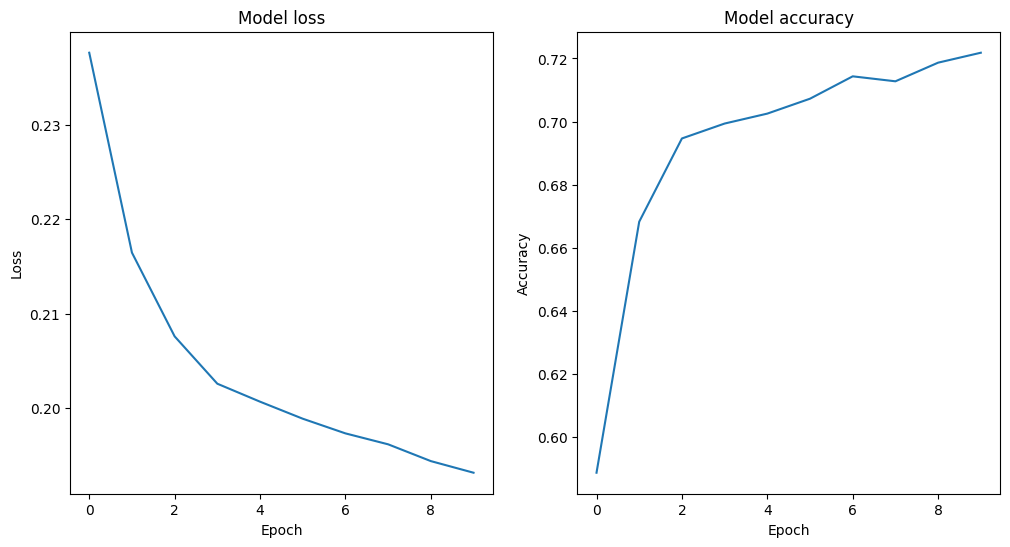

9/9 [==============================] - 5s 504ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.46      0.53       106
           1       0.72      0.84      0.77       176

    accuracy                           0.70       282
   macro avg       0.67      0.65      0.65       282
weighted avg       0.69      0.70      0.68       282



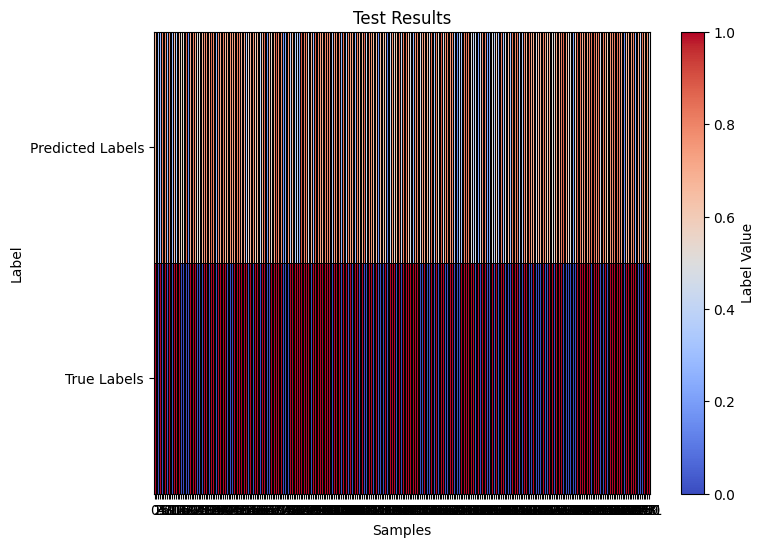

9/9 [==============================] - 3s 317ms/step


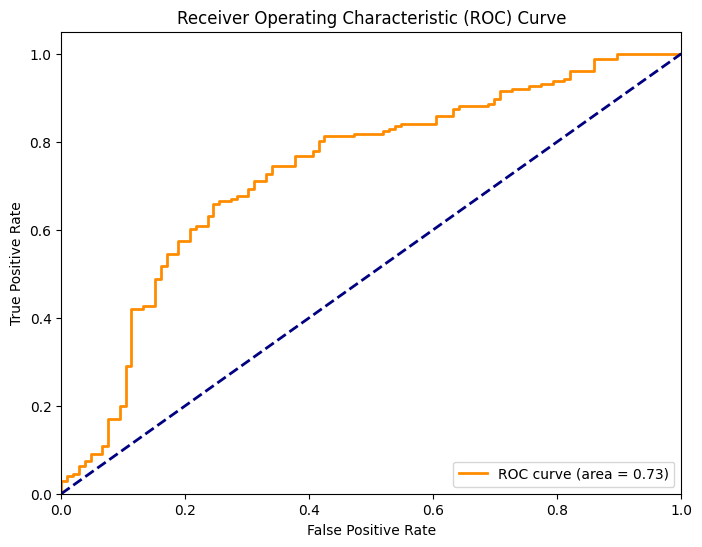

9/9 [==============================] - 3s 308ms/step


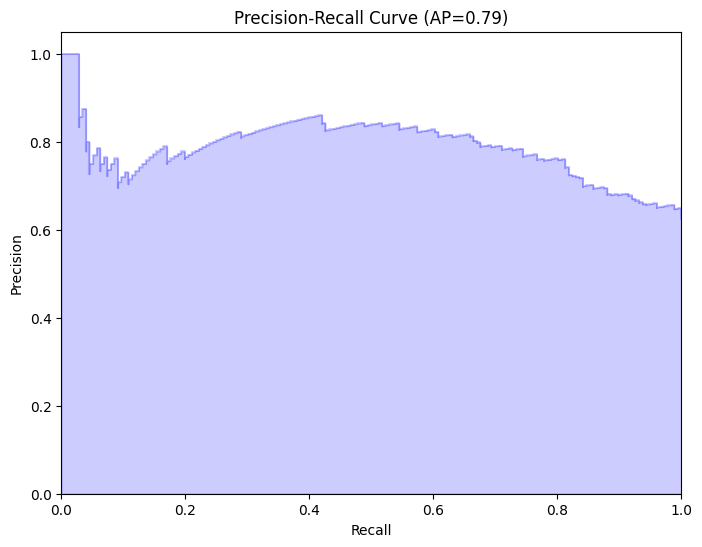

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split


class SignatureNeuralNetwork:
    def __init__(self, input_size):
        self.model = self.build_model(input_size)

    def build_model(self, input_size):
        reference_input = Input(shape=(input_size,))
        reference_output = Dense(input_size, activation='relu')(reference_input)
        reference_output = Dense(input_size // 2, activation='relu')(reference_output)

        other_input = Input(shape=(input_size,))
        other_output = Dense(input_size, activation='relu')(other_input)
        other_output = Dense(input_size // 2, activation='relu')(other_output)

        merged = Concatenate()([reference_output, other_output])

        x = Dense(10, activation='relu')(merged)
        x = Dense(5, activation='relu')(x)
        output = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[reference_input, other_input], outputs=output)
        optimizer = SGD(learning_rate=0.01)
        model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
        return model

    def train(self, X_reference, X_other, y, epochs=10, batch_size=32):
        history = self.model.fit([X_reference, X_other], y, epochs=epochs, batch_size=batch_size, verbose=1)
        self.plot_learning_curve(history)

    def predict(self, X_reference, X_other):
        return self.model.predict([X_reference, X_other])

    def evaluate(self, X_reference_test, X_other_test, y_test):
        y_pred = np.squeeze(self.model.predict([X_reference_test, X_other_test]))
        print("Classification Report:")
        print(classification_report(y_test, np.round(y_pred)))
        self.plot_test_results(y_test, y_pred)
        self.plot_roc_curve(X_reference_test, X_other_test, y_test)
        self.plot_precision_recall_curve(X_reference_test, X_other_test, y_test)

    def plot_precision_recall_curve(self, X_reference_test, X_other_test, y_test):
        y_pred = np.squeeze(self.model.predict([X_reference_test, X_other_test]))

        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        average_precision = average_precision_score(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Curve (AP={:.2f})'.format(average_precision))
        plt.show()

    def plot_roc_curve(self, X_reference_test, X_other_test, y_test):
        y_pred = np.squeeze(self.model.predict([X_reference_test, X_other_test]))

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()


    def plot_learning_curve(self, history):
        plt.figure(figsize=(12, 6))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.title('Model loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'])
        plt.title('Model accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')

        plt.show()

    def plot_test_results(self, y_true, y_pred):
        plt.figure(figsize=(8, 6))

        # Flatten the 2D arrays
        y_true = np.squeeze(y_true)
        y_pred = np.squeeze(y_pred)

        # Plotting the test results without lines
        plt.pcolormesh([y_true, y_pred], cmap='coolwarm', edgecolors='k', linewidth=0.5)

        plt.yticks([0.5, 1.5], ['True Labels', 'Predicted Labels'])
        plt.xticks(np.arange(len(y_true)) + 0.5, np.arange(len(y_true)))

        plt.xlabel('Samples')
        plt.ylabel('Label')
        plt.title('Test Results')
        plt.colorbar(label='Label Value')

        plt.show()


# Adatok előkészítése
max_input_size = database.get_max_input_size()
X_reference = []
X_other = []
y = []

# Tanító és tesztelő adatok előkészítése
for person in database.persons:
    # Minden személyhez tartozik egy referencia aláírás
    reference_signature = person.get_reference_signature()

    for signature in person.get_all_signatures():
        # A tanító és tesztelő adatokhoz az eredeti referencia aláírás mellett választunk egy másikat
        X_reference.append(reference_signature.net_input.flatten())
        X_other.append(signature.net_input.flatten())
        y.append(1 if signature.is_original else 0)  # Az eredetiség alapján két osztályba soroljuk

X_reference = np.array(X_reference)
X_other = np.array(X_other)
y = np.array(y)

# Adatok felosztása tanító és tesztelő halmazra
X_ref_train, X_ref_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_reference, X_other, y, test_size=0.1, random_state=42
)

# Hálózat létrehozása és tanítása
net_input_size = len(X_ref_train[0])
signature_nn = SignatureNeuralNetwork(net_input_size)
history = signature_nn.train(X_ref_train, X_other_train, y_train)

# Tesztelés
signature_nn.evaluate(X_ref_test, X_other_test, y_test)